Load Modules

In [1]:
# Essential Imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#Dataset repo
from ucimlrepo import fetch_ucirepo

# Models Import
from algorithms import CustomKNNClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# KNN Classifier hyperparameters

k = 5
metric = 'euclidean'

In [3]:
dataset_dict = {
    0 : {
        'label' : 'd1',
        'name' : 'Breast Cancer',
        'data' : fetch_ucirepo(id=17)
    },
    1 : {
        'label' : 'd2',
        'name' : 'Wine Quality',
        'data' : fetch_ucirepo(id=186)
    },
    2 : {
        'label' : 'd3',
        'name' : 'iris',
        'data' : fetch_ucirepo(id=53)
    }
}

In [4]:
classifiers = {
    0 : {
        'label' : 'c1',
        'name' : 'CustomKNNClassifier',
        'model' : CustomKNNClassifier(k=k, metric=metric),
    },
    1 : {
        'label' : 'c2',
        'name' : 'KNeighboursClassifier',
        'model' : KNeighborsClassifier(n_neighbors=k, metric=metric)
    },
    2 : {
        'label' : 'c3',
        'name' : 'GaussianNB',
        'model' : GaussianNB()
    }
}

In [5]:
class Classifier:
    def __init__(self, model, X_train, y_train, X_test, y_true):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_true = y_true
        
        self.y_pred = None
        self.train_time = None
        self.predict_time = None
        self.accuracy = None
        self.conf_matrix = None

    def fit(self):
        start_train = time.time()
        self.model = self.model.fit(self.X_train,self.y_train)
        self.train_time = time.time() - start_train
    
    def predict(self):
        start_predict = time.time()
        self.y_pred = self.model.predict(self.X_test)
        self.predict_time = time.time() - start_predict
        
        self._calculate_metrics()

        return self.y_pred
    
    def _calculate_metrics(self):
        self.accuracy = accuracy_score(y_true=self.y_true, y_pred=self.y_pred)
        self.conf_matrix = confusion_matrix(y_true=self.y_true, y_pred=self.y_pred)


Classifier -  CustomKNNClassifier  | Dataset -  Breast Cancer
Accuracy -  0.9210526315789473
Training time -  1.9073486328125e-06
Prediction time -  0.1433699131011963
Confusion Matrix - 
 [[68  4]
 [ 5 37]]


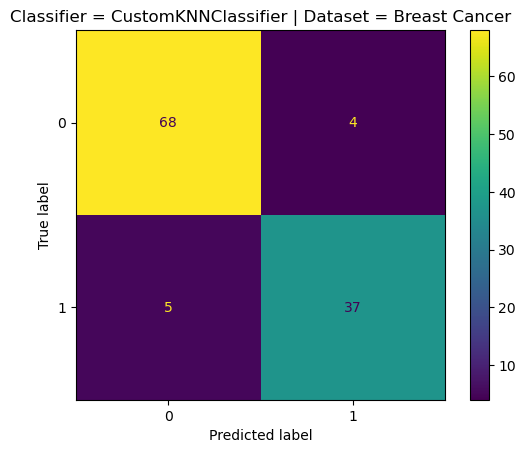

--------------------------------------------------
Classifier -  KNeighboursClassifier  | Dataset -  Breast Cancer
Accuracy -  0.9210526315789473
Training time -  0.00046372413635253906
Prediction time -  0.025442123413085938
Confusion Matrix - 
 [[68  4]
 [ 5 37]]


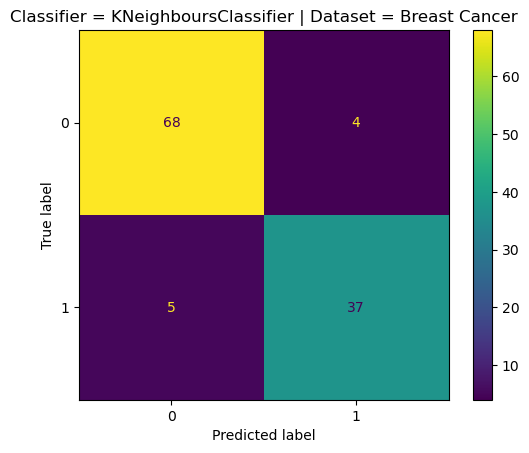

--------------------------------------------------
Classifier -  GaussianNB  | Dataset -  Breast Cancer
Accuracy -  0.9035087719298246
Training time -  0.001302957534790039
Prediction time -  0.00019598007202148438
Confusion Matrix - 
 [[67  5]
 [ 6 36]]


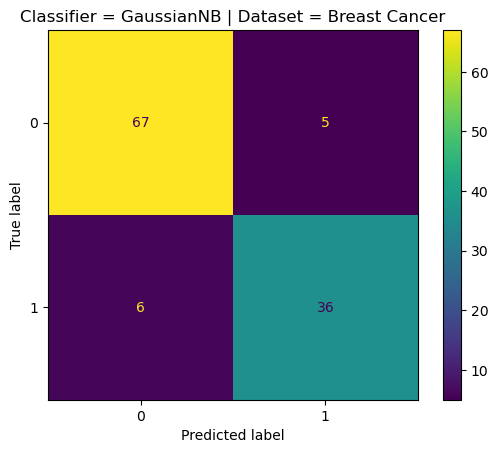

--------------------------------------------------
Classifier -  CustomKNNClassifier  | Dataset -  Wine Quality
Accuracy -  0.52
Training time -  5.9604644775390625e-06
Prediction time -  16.85837411880493
Confusion Matrix - 
 [[  0   0   4   1   1   0   0]
 [  0   2  25  13   2   1   0]
 [  0   3 219 182  21   3   0]
 [  0   1 137 352  70   7   0]
 [  0   0  29  89  95   3   0]
 [  0   0   7  17   7   8   0]
 [  0   0   0   1   0   0   0]]


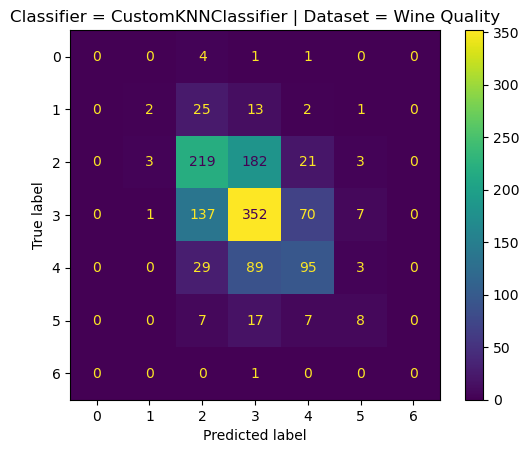

--------------------------------------------------
Classifier -  KNeighboursClassifier  | Dataset -  Wine Quality
Accuracy -  0.5053846153846154
Training time -  0.0017819404602050781
Prediction time -  0.02021193504333496
Confusion Matrix - 
 [[  0   0   4   1   1   0   0]
 [  0   2  29  10   2   0   0]
 [  0   5 235 172  13   3   0]
 [  0   7 162 346  47   5   0]
 [  0   2  41 102  69   2   0]
 [  0   0  10  16   8   5   0]
 [  0   0   0   1   0   0   0]]


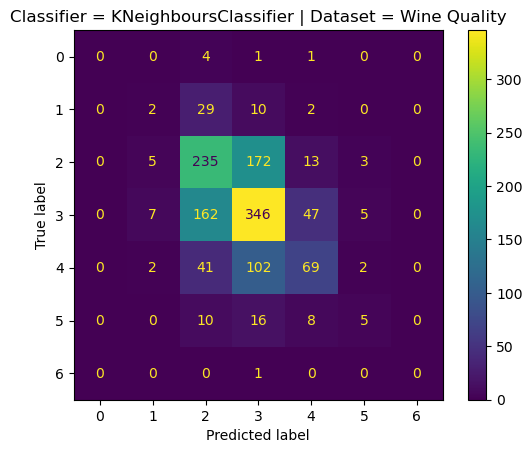

--------------------------------------------------
Classifier -  GaussianNB  | Dataset -  Wine Quality
Accuracy -  0.4461538461538462
Training time -  0.0013971328735351562
Prediction time -  0.00036406517028808594
Confusion Matrix - 
 [[  2   1   1   1   1   0   0]
 [  2   7  20   9   5   0   0]
 [  4  12 230 147  35   0   0]
 [  7  14 153 233 158   0   2]
 [  1   8  20  77 106   1   3]
 [  0   0   6   7  23   2   1]
 [  0   0   0   1   0   0   0]]


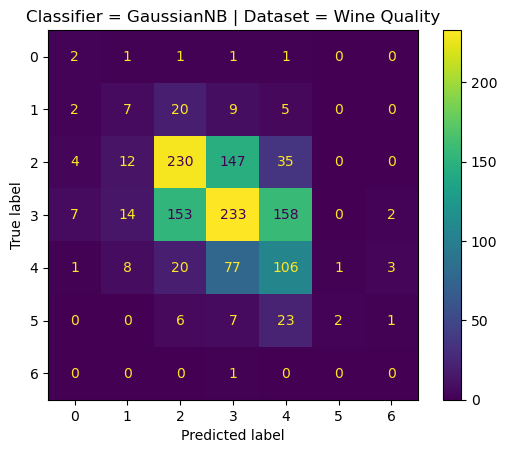

--------------------------------------------------
Classifier -  CustomKNNClassifier  | Dataset -  iris
Accuracy -  0.9333333333333333
Training time -  1.1920928955078125e-06
Prediction time -  0.009960174560546875
Confusion Matrix - 
 [[10  0  0]
 [ 0  8  2]
 [ 0  0 10]]


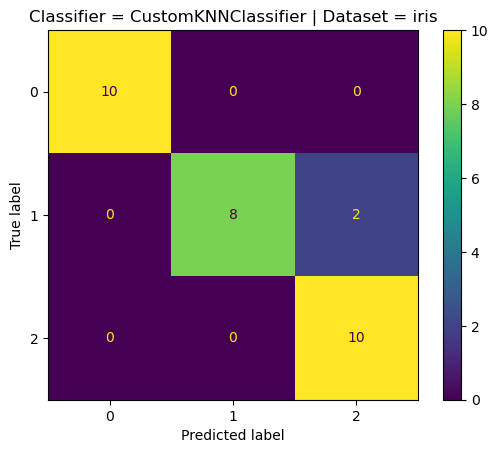

--------------------------------------------------
Classifier -  KNeighboursClassifier  | Dataset -  iris
Accuracy -  0.9333333333333333
Training time -  0.00047016143798828125
Prediction time -  0.0012979507446289062
Confusion Matrix - 
 [[10  0  0]
 [ 0  8  2]
 [ 0  0 10]]


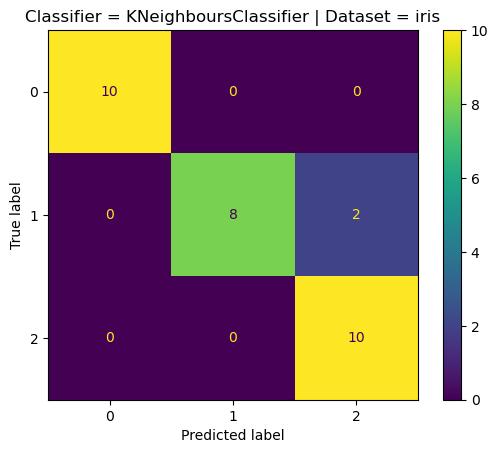

--------------------------------------------------
Classifier -  GaussianNB  | Dataset -  iris
Accuracy -  0.9333333333333333
Training time -  0.00041294097900390625
Prediction time -  8.702278137207031e-05
Confusion Matrix - 
 [[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


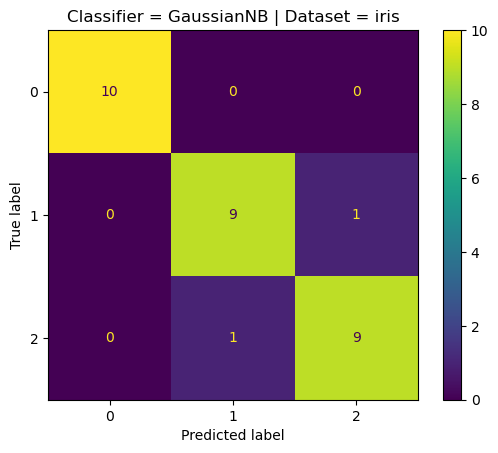

--------------------------------------------------


In [6]:
for _, dataset in dataset_dict.items():
    X = dataset['data'].data.features.to_numpy()
    y = dataset['data'].data.targets.to_numpy().flatten()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    for _, cf in classifiers.items():
        model = Classifier(model=cf['model'],X_train=X_train, y_train=y_train, X_test=X_test, y_true=y_test)

        model.fit()
        y_pred = model.predict()

        df = pd.DataFrame(model.conf_matrix,
                          index=[f'Actual_{i}' for i in range(model.conf_matrix.shape[0])],
                          columns=[f'Predicted_{i}' for i in range(model.conf_matrix.shape[1])])
        
        df.to_csv(f'results/g018_{dataset['label']}_{cf['label']}.csv')
        
        disp = ConfusionMatrixDisplay(confusion_matrix=model.conf_matrix)

        print('Classifier - ', cf['name'], ' | Dataset - ', dataset['name'])
        print('Accuracy - ', model.accuracy)
        print('Training time - ', model.train_time)
        print('Prediction time - ', model.predict_time)
        print(f'Confusion Matrix - \n', model.conf_matrix)
        disp.plot()

        plt.title(label=f'Classifier = {cf['name']} | Dataset = {dataset['name']}')
        plt.show()
        print('-' * 50)